In [117]:
# in the previous code the elements were rectangles/quadrilaterals
# -> in this code they are BARS (LINES) = simpler!
# useful reference by Mert Solen (https://youtu.be/tv1TlAebvm0)

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# auxiliary ftions: extended_nodes updates
# returns local DOF matrix, global DOF matrix, tot num of DOC, tot num of DOF
def get_DOF(nodes, BC):
    num_nodes, PD = len(nodes), len(nodes[0])

    DOF = 0  # degrees of freedom
    DOC = 0  # degrees of constraint

    local_DOF = np.zeros((num_nodes, PD))
    global_DOF = np.zeros((num_nodes, PD))

    for i in range(num_nodes):
        for j in range(PD):
            if BC[i, j] == -1:
                DOC -= 1
                local_DOF[i, j] = DOC
            else:
                DOF += 1
                local_DOF[i, j] = DOF

    for i in range(num_nodes):
        for j in range(PD):
            if local_DOF[i, j] < 0:
                global_DOF[i, j] = abs(local_DOF[i, j]) + DOF
            else:
                global_DOF[i, j] = abs(local_DOF[i, j])

    return (local_DOF, global_DOF, abs(DOC), abs(DOF))

# obtain the element stiffness matrix based on the list of nodes in an element (el_list)
def get_element_stiffness(el_list, ext_nodes, E, A):
    X1 = ext_nodes[el_list[0], 0]
    Y1 = ext_nodes[el_list[0], 1]
    X2 = ext_nodes[el_list[1], 0]
    Y2 = ext_nodes[el_list[1], 1]

    L = np.sqrt((X1 - X2)**2 + (Y1 - Y2)**2)
    c = (X2 - X1) / L
    s = (Y2 - Y1) / L
    KE = E*A/L * np.array([[c**2, c * s, -c**2, -c * s],
                           [c * s, s**2, - c * s, -s**2],
                           [-c**2, -c * s, c**2, c * s],
                           [-c * s, -s**2, s * c, s**2]])
    return KE

# assemble the stiffness matrix K
def get_global_stiffness(nodes, conn, ext_nodes, E, A):
    num_nodes, num_el, PD = len(nodes), len(conn), len(nodes[0])
    K = np.zeros((num_nodes * PD, num_nodes * PD))  # init (global) stiffness matrix
    L = [np.sqrt(nodes[i,0]**2 + nodes[i,1]**2) for i in range(len(conn))]
    for i in range(num_el):  # obtain individual element stiffnesses
        element_list = conn[i,:]
        KE = get_element_stiffness(element_list, ext_nodes, E, A)
        for k in range(len(element_list)):  # for each node within element
            for l in range(PD):             # get each coordinate
                for m in range(len(element_list)):
                    for n in range(PD):
                        row = ext_nodes[element_list[k], l + 3*PD]
                        col = ext_nodes[element_list[m], n + 3*PD]
                        val = KE[k*PD + l, m*PD + n]

                        K[int(row) - 1, int(col) - 1] += val
    return K

# assemble the unknown forces
def get_forces(nodes, ext_nodes):
    num_nodes, PD = len(nodes), len(nodes[0])
    DOF = 0
    F_new = []

    for i in range(num_nodes):  # for each node
        for j in range(PD):     # for each dimension
            if ext_nodes[i, PD + j] == 1: # if node is not fixed
                DOF += 1
                F_new.append(ext_nodes[i, 5*PD+j])
    return np.array(F_new)

# assemble the unknown displacements
def get_displacements(nodes, ext_nodes):
    num_nodes, PD = len(nodes), len(nodes[0])
    DOC = 0
    U_new = []

    for i in range(num_nodes):  # for each node
        for j in range(PD):     # for each dimension
            if ext_nodes[i, PD + j] == -1: # if node is not fixed
                DOC += 1
                U_new.append(ext_nodes[i, 4*PD+j])
    return np.array(U_new)

# updates the extended nodes with the solution values for displacements and forces
def update_ext_nodes(nodes, ext_nodes, U_new, F_u):
    num_nodes, PD = len(nodes), len(nodes[0])

    DOF = 0  # degrees of freedom
    DOC = 0  # degrees of constraint

    for i in range(num_nodes):
        for j in range(PD):
            if ext_nodes[i, PD+j] == 1:
                DOF += 1
                ext_nodes[i, 4*PD + j] = U_new[DOF - 1]
            else:
                DOC += 1
                ext_nodes[i, 5*PD + j] = F_u[DOC - 1]
    return ext_nodes

# plotting nodes: numpy array of xs and ys
def plot_nodes(nodes, size=10):
    plt.figure(figsize=(size,size))
    plt.grid(color = 'gray', linewidth=0.2)
    plt.scatter(nodes[:,0], nodes[:,1], marker='o')
    plt.axis('equal')
    plt.title(f"num of nodes {num_nodes}")
    if size >= 8:  # print node labels
        for i,(x,y) in enumerate(nodes):
            plt.text(x, y, str(i))
    plt.show()


In [118]:
# material specifications
E = 10.0 ** 6   # Youngs modulus
A = 0.01        # cross-section area of a bar

# defining the structure
nodes = np.array([[0, 0],
                  [1, 0],
                  [0.5, 1]])
conn = np.array([[0, 1],
                 [1, 2],
                 [2, 0]])
num_nodes = len(nodes)  # total number of nodes
PD = 2                  # problem dimension: 2D

# assigning boundary conditions
BC = np.array([[-1, -1],  # Dirichlet & Neumann Boundary Conditions
               [1, -1],
               [1, 1]])
    # (-1,-1) -> fixed in X and Y
    # ( 1,-1) -> free to move in X and fixed in Y

# assigning nodal forces
F = np.array([[0,  0],
              [0,  0],
              [0, -20]])

# initial displacements
U = np.array([[0, 0],
              [0, 0],
              [0, 0]])

# extended node list (ENL)
(localDOF, globalDOF, DOC, DOF) = get_DOF(nodes=nodes, BC=BC)  # get the DOF matrices
ext_nodes = np.zeros((num_nodes, 6 * PD))  # nodes, BC, local DoF, global DoF, Displacement, Forces
ext_nodes[:, 0:PD] = nodes          # first 2 columns are node list
ext_nodes[:, PD:2*PD] = BC          # boundary conditions
ext_nodes[:, 2*PD:3*PD] = localDOF  # local DOFs
ext_nodes[:, 3*PD:4*PD] = globalDOF # global DOFs
ext_nodes[:, 4*PD:5*PD] = U         # displacements
ext_nodes[:, 5*PD:6*PD] = F         # forces

K = get_global_stiffness(nodes=nodes, conn=conn, ext_nodes=ext_nodes, E=E, A=A)  # calculating global stiffness
U, F = U.flatten(), F.flatten()
print(F.shape)


# finding the new displacements and forces
F_p = get_forces(nodes, ext_nodes)        # force prescribed
U_p = get_displacements(nodes, ext_nodes) # displacement prescribed

print(F_p.shape)

# using F = K * U
K_UU = K[0:DOF, 0:DOF]
K_UP = K[0:DOF, DOF:DOF+DOC]
K_PU = K[DOF:DOF+DOC, 0:DOF]
K_PP = K[DOF:DOF+DOC, DOF:DOF+DOC]


F_com = F_p - np.matmul(K_UP, U_p)                            # 'combined' F
U_new = np.matmul(np.linalg.inv(K_UU), F_com)                 # the nodal displacements
F_new = np.matmul(K_PU, U_new) + np.matmul(K_PP, U_p)         # the nodal forces
ext_nodes = update_ext_nodes(nodes, ext_nodes, U_new, F_new)  # matrix with solutions

print(F_com.shape)
print(F_com, U_new, F_new)

print(ext_nodes)



(6,)
(3,)
(3,)
[  0.   0. -20.] [ 0.0005      0.00025    -0.00152254] [-8.8817842e-16  1.0000000e+01  1.0000000e+01]
[[ 0.00000000e+00  0.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -2.00000000e+00  4.00000000e+00  5.00000000e+00
   0.00000000e+00  0.00000000e+00 -8.88178420e-16  1.00000000e+01]
 [ 1.00000000e+00  0.00000000e+00  1.00000000e+00 -1.00000000e+00
   1.00000000e+00 -3.00000000e+00  1.00000000e+00  6.00000000e+00
   5.00000000e-04  0.00000000e+00  0.00000000e+00  1.00000000e+01]
 [ 5.00000000e-01  1.00000000e+00  1.00000000e+00  1.00000000e+00
   2.00000000e+00  3.00000000e+00  2.00000000e+00  3.00000000e+00
   2.50000000e-04 -1.52254249e-03  0.00000000e+00 -2.00000000e+01]]


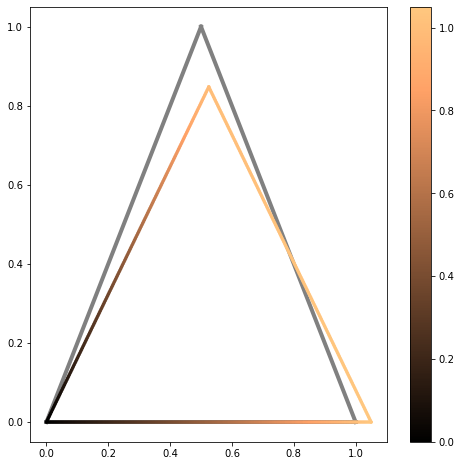

In [161]:
ex = 100               # exaggerate the displacement (for display)
interpolation_num = 200  # how many points to add in each element
num_nodes, num_el, PD = len(nodes), len(conn), len(nodes[0])


x_new = nodes[:, 0] + ex * ext_nodes[:, 8]  # new coordinates x
y_new = nodes[:, 1] + ex * ext_nodes[:, 9]  # new coordinates y
x_old = ext_nodes[:, 0]                    # initial coordinates x
y_old = ext_nodes[:, 1]                    # initial coordinates y
U_xy = ext_nodes[:, 9:11]              # displacements [x,y]
U_abs = np.sqrt(x_new**2 + y_new**2)   # absolute displacements




xs, ys, colors = [], [], []    # init plotting points and colors
# plotting the lines with different colors (linearly interpolated points)
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_new[inds[0]], y_new[inds[0]]
    x2, y2 = x_new[inds[1]], y_new[inds[1]]
    if x1 == x2:
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = np.linspace(y1, y2, interpolation_num)
    else:
        a = (y2 - y1)/(x2 - x1)  # slope
        xs_i = np.linspace(x1, x2, interpolation_num)
        ys_i = a*(xs_i - x1) + y1

    xs.append(xs_i)
    ys.append(ys_i)
    colors.append(np.linspace(U_abs[inds[0]], U_abs[inds[1]], interpolation_num))
xs, ys, colors = np.array(xs), np.array(ys), np.array(colors)
xs, ys, colors = xs.flatten(), ys.flatten(), colors.flatten()

f1 = plt.figure(figsize=(8,8)) # init the figure
ax1 = f1.add_subplot(111)      # init the axes

# plotting the original structure
for i in range(num_el):  # for each element
    inds = conn[i]
    x1, y1 = x_old[inds[0]], y_old[inds[0]]
    x2, y2 = x_old[inds[1]], y_old[inds[1]]
    ax1.plot([x1, x2], [y1, y2], linewidth=4, color='gray', marker='', zorder=1)

# plotting the new displacements
cmap = plt.get_cmap('copper')
ax1.scatter(xs, ys, c=colors, cmap=cmap, s=12, edgecolor='None', zorder=2)
color_scale = Normalize(np.abs(colors.min()), np.abs(colors.max()))  # scale to use in the colorbar
f1.colorbar(ScalarMappable(norm=color_scale, cmap=cmap))

plt.show()

In [145]:
colors

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

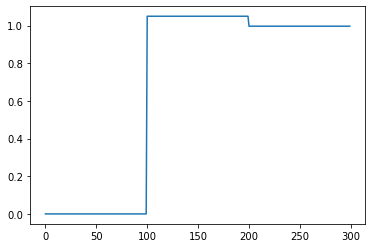

In [146]:
plt.plot(colors)